# GenJAXjl &mdash; Importance Sampling

In [1]:
#|default_exp importance

In [2]:
#|export
import genjax
from genjax import gen
import jax.numpy as jnp
import jax
from jax import jit, vmap

In [3]:
console = genjax.pretty(show_locals=False)

In [4]:
#|export
def keysplit(key, *ns):
    if len(ns) == 0:
        return jax.random.split(key, 1)[0]
    
    if len(ns) == 1:
        return jax.random.split(key, ns[0])
    else:

        keys = []
        for n in ns:
            if n == 1: keys.append(jax.random.split(key, 1)[0])
            else: keys.append(jax.random.split(key, n))

        return keys

In [5]:
#|export
logsumexp = jax.scipy.special.logsumexp
vmap      = jax.vmap

In [6]:
#|export
#
# Gen.jl style ordering of the args and return values
#
def _merge(x,y): return x.merge(y)


def _simulate(key, model, args):
    return model.simulate(key, args)


def _propose(key, model, args):
    tr = model.simulate(key, args)
    # Note: `strip` returns a stripped choice map
    return (tr.strip(), tr.get_score(), tr.get_retval())


def _generate(key, model, args, constr):
    (w, tr) = model.importance(key, constr, args)
    return (tr, w)


def _importance_sampling(key, 
                        model, args, obs, 
                        proposal, proposal_args,   
                        N:int):
    """
    Importance sampling with custom proposal 

    Usage:
    ```python

        N = 100
        _importance_sampling_jit = jit(partial(_importance_sampling, N=N))
        key, (trs, ws, lml) = _importance_sampling_jit(key, model, args, obs, prop, prop_args)

    ```
    """


    # Get some proposed choices
    key, keys = keysplit(key,1,N)
    (prop_ch, prop_ws, _) = vmap(_propose, (0, None, None))(
        keys, proposal, proposal_args)
    
    # Merge observations and proposal choices
    constr, _ = vmap(_merge, (0,None))(prop_ch, obs)

    # Generate new traces given these new constraints
    key, keys = keysplit(key,1,N)
    (trs, ws) = vmap(_generate, in_axes=(0,None,None,0))(
        keys, model, args, constr)
    
    # Adjust the importance weights accordingly
    ws    = ws - prop_ws
    total = logsumexp(ws)
    ws    = ws - total          # Log normalize
    lml   = total - jnp.log(N)  # Estimate of the (log) marginal likelihood

    return (trs, ws, lml)



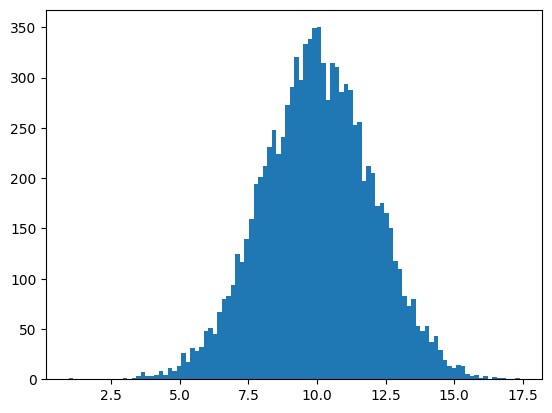

In [8]:
import matplotlib.pyplot as plt
from functools import partial

@gen
def model():
    y = genjax.normal(0.0,1.0) @ "y"
    x = genjax.normal(y, 1.0)  @ "x"
    return x

@gen
def prop(x):
    y = genjax.normal(x,2.0) @ "y"
    return y

key = jax.random.PRNGKey(0)

args = ()
prop_args = (10.,)

# obs = genjax.choice_map({'y': jnp.array([1.0])})
# obs = genjax.choice_map({'y': 1.0})
obs = genjax.choice_map({})

(w,tr) = model.importance(key, obs, args)
tr.get_choices()


args = ()
prop_args = (10.,)
obs   = genjax.choice_map({"x": 3.14})

N = 10_000
_importance_sampling_jit = jit(partial(_importance_sampling, N=N))

(trs, ws, lml) = _importance_sampling_jit(key, model, args, obs, prop, prop_args)

plt.hist(trs["y"], bins=100);

In [235]:
key = keysplit(key)
%timeit -n 1 -r 1 _importance_sampling_jit(key, model, model_args, observations, proposal, proposal_args);

440 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
